# DS2500 Day 13

Content:
- Cross Validation
- Measuring Binary Classifier Performance

Admin:
- hw4 due tonight
- proposal due next monday
    - anybody want to workshop one live here at the start of class?

# Claim: I know what your favorite number is

(activity motivating cross validation)

# In Class Assignment 1

Use the given 1-nearest neighbor classifier which estimates a penguins `species` by observing its `bill_depth_mm` and `bill_length_mm` to:
- Plot a confusion matrix which shows the performance of your classifier
- In a few sentences, explain whether this confusion matrix accurately represents the performance of the classifier on **new** penguins (those the classifier hasn't trained on).  Why or why not?  How might you fix this issue?

In [1]:
import pandas as pd
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

df_penguin = sns.load_dataset('penguins')
df_penguin.dropna(how='any', inplace=True)

In [2]:
k = 1
x_feat_list = ['bill_depth_mm', 'bill_length_mm']
y_feat = 'species'

x = df_penguin.loc[:, x_feat_list].values
y_true = df_penguin.loc[:, y_feat].values

# initialize a knn_classifier
knn_classifier = KNeighborsClassifier(n_neighbors=k)

# fit happens "inplace", we modify the internal state of knn_classifier to remember all the training samples
knn_classifier.fit(x, y_true)

# estimate each penguin's species
y_pred = knn_classifier.predict(x)

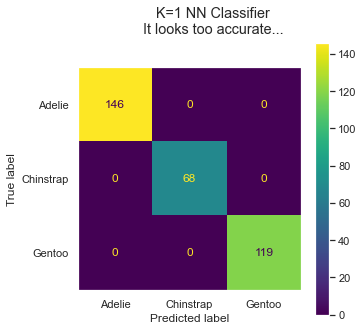

In [3]:
conf_mat = confusion_matrix(y_true=y_true, y_pred=y_pred)

conf_mat_disp = ConfusionMatrixDisplay(conf_mat, display_labels=np.unique(y_true))

sns.set(font_scale=1)
conf_mat_disp.plot()
plt.suptitle("K=1 NN Classifier\nIt looks too accurate...")

plt.gcf().set_size_inches(5, 5)

# seaborn turns on grid by default
plt.grid(False)

Too accurate because they are using training self
using crross validation - measure the perforrmance on new sample



## Cross Validation

Our motivation behind the confusion matrix was to quantify how well our classifier performs on samples it **hasn't** seen yet.  
- We built the classifier estimate the group of a new samples, we already know the group of every sample in the training set!

# To estimate classifier classifier performance on new samples...
## ... we must measure its performance on samples it hasn't been trained on

### K-Fold Cross Validation

1. Partition the data into K distinct "folds" (subset of the data)
1. For each fold i:
    - train the model on all but the i-th fold
    - test the model on the i-th fold
    
   
<img src="https://i.ibb.co/ncmWNy2/Screenshot-from-2022-03-24-15-30-16.png" width=500px>
    
Animated:

http://assets.yihui.org/figures/animation/example/cv-ani/demo-a.mp4

## Cross Validation in `sklearn`

Silly example dataset:
- Using the `favorite number` and `letters in name` to predict which of the beatles `takes milk in coffee`

In [4]:
from sklearn.model_selection import KFold
import pandas as pd

df_beatles = pd.DataFrame({'name': ['john', 'ringo', 'paul', 'george'],
                          'favorite number': [0, 2, 104, -5],
                          'letters in name': [4, 5, 4, 6],
                          'takes milk in coffee': [True, True, False, False]})
df_beatles

,name,favorite number,letters in name,takes milk in coffee
0,john,0,4,True
1,ringo,2,5,True
2,paul,104,4,False
3,george,-5,6,False


In [5]:
x_feat_list = ['favorite number', 'letters in name']
y_feat = 'takes milk in coffee'

# extract the values as np.arrays
x = df_beatles.loc[:, x_feat_list].values
y = df_beatles.loc[:, y_feat].values

# construction of kfold object
kfold = KFold(n_splits=4)

for train_idx, test_idx in kfold.split(x, y):
    print('in this iteration:')    
    name_train = list(df_beatles.loc[train_idx, 'name'])
    name_test = list(df_beatles.loc[test_idx, 'name'])
    print(f'we train on idx: {train_idx} (i.e. {name_train})')
    print(f'we test on idx: {test_idx} (i.e. {name_test})')
    print('-'*10)

in this iteration:
we train on idx: [1 2 3] (i.e. ['ringo', 'paul', 'george'])
we test on idx: [0] (i.e. ['john'])
----------
in this iteration:
we train on idx: [0 2 3] (i.e. ['john', 'paul', 'george'])
we test on idx: [1] (i.e. ['ringo'])
----------
in this iteration:
we train on idx: [0 1 3] (i.e. ['john', 'ringo', 'george'])
we test on idx: [2] (i.e. ['paul'])
----------
in this iteration:
we train on idx: [0 1 2] (i.e. ['john', 'ringo', 'paul'])
we test on idx: [3] (i.e. ['george'])
----------


In [6]:
# np.empty allocates a new array of given shape
# (no guarantees about the values inside!)
import numpy as np
np.empty((2, 10))

array([[282.15      ,  45.        , 282.15      ,  46.06171875,
        282.15      , 315.73828125, 282.15      , 316.8       ,
        295.74      , 316.8       ],
       [295.74      , 315.73828125, 295.74      ,  46.06171875,
        295.74      ,  45.        , 295.74      ,  45.        ,
        282.15      ,  45.        ]])

In [7]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold

# parameters of classifier
k = 1
x_feat_list = ['favorite number', 'letters in name']
y_feat = 'takes milk in coffee'

# extract the values as np.arrays
x = df_beatles.loc[:, x_feat_list].values
y = df_beatles.loc[:, y_feat].values

# initialize classifier
knn_class = KNeighborsClassifier(n_neighbors=k)

# initialize of kfold object
kfold = KFold(n_splits=4)

# initialize an array of same shape and type as y
y_pred = np.empty(y.shape)
for train_idx, test_idx in kfold.split(x, y):
    # split into train and test sets
    x_train = x[train_idx, :]
    y_train = y[train_idx]
    x_test = x[test_idx, :]
    
    # fit classifier (on training set)
    knn_class.fit(x_train, y_train)
    
    # predict (on testing set)
    y_pred[test_idx] = knn_class.predict(x_test)

In [8]:
# y pred contains a prediction for each sample ... but not from the same classifier
y_pred

array([1., 1., 1., 1.])

## Applying Cross Validation to our penguins species classification...

In [9]:
from copy import copy

k = 1
x_feat_list = ['bill_depth_mm', 'bill_length_mm']
y_feat = 'species'

x = df_penguin.loc[:, x_feat_list].values
y_true = df_penguin.loc[:, y_feat].values

# initialize a knn_classifier
knn_classifier = KNeighborsClassifier(n_neighbors=k)

# construction of kfold object
kfold = KFold(n_splits=3)

# allocate an empty array to store predictions in
y_pred = copy(y_true)

for train_idx, test_idx in kfold.split(x, y_true):
    # build arrays which correspond to x, y train /test
    x_test = x[test_idx, :]
    x_train = x[train_idx, :]
    y_true_train = y_true[train_idx]
    
    # fit happens "inplace", we modify the internal state of knn_classifier to remember all the training samples
    knn_classifier.fit(x_train, y_true_train)

    # estimate each penguin's species
    y_pred[test_idx] = knn_classifier.predict(x_test)

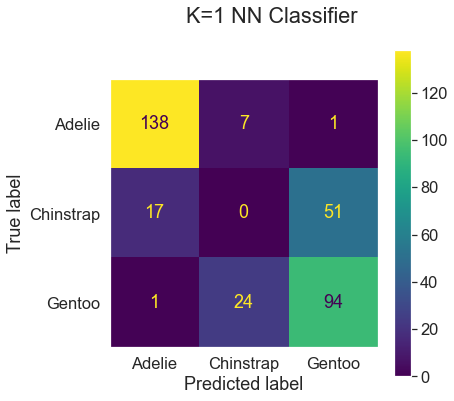

In [10]:
# build and plot confusion matrix
conf_mat = confusion_matrix(y_true=y_true, y_pred=y_pred)
conf_mat_disp = ConfusionMatrixDisplay(conf_mat, display_labels=np.unique(y_true))

sns.set(font_scale=1.5)
conf_mat_disp.plot()
plt.suptitle('K=1 NN Classifier')
plt.gcf().set_size_inches(6, 6)
plt.grid(False)

## How come we don't get any chinstraps correct?

hint: count the `species` in each set of training data.

In [11]:
from copy import copy
from collections import Counter

k = 1
x_feat_list = ['bill_depth_mm', 'bill_length_mm']
y_feat = 'species'

x = df_penguin.loc[:, x_feat_list].values
y_true = df_penguin.loc[:, y_feat].values

# initialize a knn_classifier
knn_classifier = KNeighborsClassifier(n_neighbors=k)

# construction of kfold object
kfold = KFold(n_splits=3)

# allocate an empty array to store predictions in
y_pred = copy(y_true)

for train_idx, test_idx in kfold.split(x, y_true):
    # build arrays which correspond to x, y train /test
    x_test = x[test_idx, :]
    x_train = x[train_idx, :]
    y_true_train = y_true[train_idx]
    
    print(f'trained on: {Counter(y_true_train)}')
    print(f'tested on: {Counter(y_true[test_idx])}')
    print('-' * 10)
    
    # fit happens "inplace", we modify the internal state of knn_classifier to remember all the training samples
    knn_classifier.fit(x_train, y_true_train)

    # estimate each penguin's species
    y_pred[test_idx] = knn_classifier.predict(x_test)

trained on: Counter({'Gentoo': 119, 'Chinstrap': 68, 'Adelie': 35})
tested on: Counter({'Adelie': 111})
----------
trained on: Counter({'Adelie': 111, 'Gentoo': 111})
tested on: Counter({'Chinstrap': 68, 'Adelie': 35, 'Gentoo': 8})
----------
trained on: Counter({'Adelie': 146, 'Chinstrap': 68, 'Gentoo': 8})
tested on: Counter({'Gentoo': 111})
----------


Notice that we don't always get a proper mix of species in each training set ... the second training set doesn't even have any Chinstrap penguins!

Why is this?

In [12]:
# Adelie penguins up front, then chinstrap, finally all gentoo
y_true

array(['Adelie', 'Adelie', 'Adelie', 'Adelie', 'Adelie', 'Adelie',
       'Adelie', 'Adelie', 'Adelie', 'Adelie', 'Adelie', 'Adelie',
       'Adelie', 'Adelie', 'Adelie', 'Adelie', 'Adelie', 'Adelie',
       'Adelie', 'Adelie', 'Adelie', 'Adelie', 'Adelie', 'Adelie',
       'Adelie', 'Adelie', 'Adelie', 'Adelie', 'Adelie', 'Adelie',
       'Adelie', 'Adelie', 'Adelie', 'Adelie', 'Adelie', 'Adelie',
       'Adelie', 'Adelie', 'Adelie', 'Adelie', 'Adelie', 'Adelie',
       'Adelie', 'Adelie', 'Adelie', 'Adelie', 'Adelie', 'Adelie',
       'Adelie', 'Adelie', 'Adelie', 'Adelie', 'Adelie', 'Adelie',
       'Adelie', 'Adelie', 'Adelie', 'Adelie', 'Adelie', 'Adelie',
       'Adelie', 'Adelie', 'Adelie', 'Adelie', 'Adelie', 'Adelie',
       'Adelie', 'Adelie', 'Adelie', 'Adelie', 'Adelie', 'Adelie',
       'Adelie', 'Adelie', 'Adelie', 'Adelie', 'Adelie', 'Adelie',
       'Adelie', 'Adelie', 'Adelie', 'Adelie', 'Adelie', 'Adelie',
       'Adelie', 'Adelie', 'Adelie', 'Adelie', 'Adelie', 'Adel

the data is sorted by species.

## Ensuring that each training set represents all target groups:

- we can pass the `shuffle=True` parameter to the constructor of `Kfold` so that data is shuffled before the training indexing

- alternatively, we could use a `StratifiedKFold` object in place of a plain old `Kfold`:


     "This cross-validation object is a variation of KFold that returns stratified folds. The folds are made by 
     preserving the percentage of samples for each class."  
     
taken from [sklearn doc](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html#sklearn.model_selection.StratifiedKFold)

using `shuffle=True` on a `KFold`

In [13]:
from copy import copy
from collections import Counter

k = 1
x_feat_list = ['bill_depth_mm', 'bill_length_mm']
y_feat = 'species'

x = df_penguin.loc[:, x_feat_list].values
y_true = df_penguin.loc[:, y_feat].values

# initialize a knn_classifier
knn_classifier = KNeighborsClassifier(n_neighbors=k)

# construction of kfold object
kfold = KFold(n_splits=3, shuffle=True)

# allocate an empty array to store predictions in
y_pred = copy(y_true)

for train_idx, test_idx in kfold.split(x, y_true):
    # build arrays which correspond to x, y train /test
    x_test = x[test_idx, :]
    x_train = x[train_idx, :]
    y_true_train = y_true[train_idx]
    
    print(Counter(y_true_train))
    
    # fit happens "inplace", we modify the internal state of knn_classifier to remember all the training samples
    knn_classifier.fit(x_train, y_true_train)

    # estimate each penguin's species
    y_pred[test_idx] = knn_classifier.predict(x_test)

Counter({'Adelie': 98, 'Gentoo': 76, 'Chinstrap': 48})
Counter({'Adelie': 98, 'Gentoo': 81, 'Chinstrap': 43})
Counter({'Adelie': 96, 'Gentoo': 81, 'Chinstrap': 45})


In [14]:
from sklearn.model_selection import StratifiedKFold

from copy import copy
from collections import Counter

k = 1
x_feat_list = ['bill_depth_mm', 'bill_length_mm']
y_feat = 'species'

x = df_penguin.loc[:, x_feat_list].values
y_true = df_penguin.loc[:, y_feat].values

# initialize a knn_classifier
knn_classifier = KNeighborsClassifier(n_neighbors=k)

# construction of kfold object
kfold = StratifiedKFold(n_splits=3)

# allocate an empty array to store predictions in
y_pred = copy(y_true)

for train_idx, test_idx in kfold.split(x, y_true):
    # build arrays which correspond to x, y train /test
    x_test = x[test_idx, :]
    x_train = x[train_idx, :]
    y_true_train = y_true[train_idx]
    
    print(Counter(y_true_train))
    
    # fit happens "inplace", we modify the internal state of knn_classifier to remember all the training samples
    knn_classifier.fit(x_train, y_true_train)

    # estimate each penguin's species
    y_pred[test_idx] = knn_classifier.predict(x_test)

Counter({'Adelie': 97, 'Gentoo': 80, 'Chinstrap': 45})
Counter({'Adelie': 97, 'Gentoo': 79, 'Chinstrap': 46})
Counter({'Adelie': 98, 'Gentoo': 79, 'Chinstrap': 45})


I have a mild preference for the `StratifiedKFold` since it gets us as close as possible to an even splitting of target groups.

## Note this quirk:
the resulting `y_pred` contains predictions for all the samples ...

... but samples in different folds were estimated by classifiers trained on different data

### So which of these trained classifiers should we use as our "final" classifier?

None of them, better to re-train on the whole dataset:

In [15]:
# discard previous training sets and train classifier on whole dataset
# this is best for *truly new samples 
# (*penguins whose species is unknown, not just "hidden" for evaluation purposes)
knn_classifier.fit(x, y_true)

KNeighborsClassifier(n_neighbors=1)

# Computing Accuracy

use `accuracy_score`:

In [16]:
from sklearn.metrics import accuracy_score

y_true = [0, 0, 0, 0, 1]
y_pred = [1, 1, 1, 2, 1]

accuracy_score(y_true, y_pred)

0.2

# In Class Assignment 2

One question we never answered: How do we pick the best K for a K-NN classifier?

A common solution is to try many different k and then choose the one which works "best".

<img src="https://i.ibb.co/2sc080h/best-k-penguin.png" width=00>

In this ICA, make this plot of the **cross validated** accuracy of the k-NN classifier for k = 1 to 50.
- in your cross validation, use `n_splits=10` folds of data
- write a function `get_cv_acc_knn()` which:
    - accepts:
        - `x`, `y_true`, `k` (of k-NN) as defined above
            - stick with the same classification problem where we estimate `species` from `bill_depth_mm` and `bill_length_mm`
        - `n_splits=10` (defaults)
    - returns 
        - the cross validated accuracy of k-NN on the dataset    

## Measuring Binary Classification Performance
- Accuracy
- Sensitivity
- Specificity

## "This Classifier is 90% accurate"

... is that a good thing?

Lets take a look at a few 90% accurate classifications and see for ourselves:

 ## This classifier is 90% accurate: example 0
 <img src="https://i.ibb.co/M2FFx3M/accuracy-is-vague0.png" alt="title">
 
 ... isn't there more than one way this classification can be 90% accurate?

 ## This classifier is 90% accurate: example 1
 <img src="https://i.ibb.co/z6VTVXV/accuracy-is-vague1.png" alt="title" >
 
 Assumes:
 - "fair" coin flip
 - equal accuracy in identifying heads / tails

 ## This classifier is 90% accurate: example 2
 <img src="https://i.ibb.co/ZKbpsfN/accuracy-is-vague2.png" alt="title" >
 
 Assumes:
 - "fair" coin flip
 - ~equal accuracy in identifying heads / tails~

Problems with Accuracy:
1. Doesn't describe how accuracy varies with each particular target 
    - (e.g. tails more accurately predicted than heads)
 

 ## This classifier is 90% accurate: example 3
 <img src="https://i.ibb.co/dMwVtKD/accuracy-is-vague3.png" alt="title" >
 
Assumes:
 - ~"fair" coin flip~
 - equal accuracy in identifying heads / tails
 
Problems with accuracy:
1. Doesn't describe how accuracy varies with each particular target 
    - (e.g. tails more accurately predicted than heads)
1. Doesn't describe differences in distribution of our target variable
    - (e.g. heads occurs more often than tails does) 

 ## This classifier is 90% accurate: example 4
 <img src="https://i.ibb.co/qD8B48v/accuracy-is-vague4.png" alt="title" >
 
 Regardless of how we quantify accuracy, doesn't it implicitly say something about the relative costs of each of the errors below?
 - given one has a disease predicting they are healthy
 - given one is healthy predicting they have a disease
 
Problems with accuracy:
1. Doesn't describe how accuracy varies with each particular target 
    - (e.g. tails more accurately predicted than heads)
1. Doesn't describe differences in distribution of our target variable
    - (e.g. heads occurs more often than tails does) 
1. Doesn't characterize the relative cost of each particular error
    - (e.g. missing a disease detection can harm someone's health, falsely predicting they have a disease may only inconvenience them)

 ## This classifier is 90% accurate: example 5
 <img src="https://i.ibb.co/W336XhF/accuracy-is-vague5.png" alt="title" >
 
Problems with accuracy:
1. Doesn't describe how accuracy varies with each particular target 
    - (e.g. tails more accurately predicted than heads)
1. Doesn't describe differences in distribution of our target variable
    - (e.g. heads occurs more often than tails does) 
1. Doesn't characterize the relative cost of each particular error
    - (e.g. missing a disease detection can harm someone's health, falsely predicting they have a disease may only inconvenience them)
1. Doesn't characterize the difficulty of the problem itself
    - (e.g. predicting coin flips is easier than predicting lotto numbers)
        - further reading: see use of 'entropy' in [my favorite book on info theory](http://www.inference.org.uk/mackay/itila/book.html) 

## What about our confusion matrices?

<img src='https://i.ibb.co/YkNcR9P/conf-mat-penguin-knn.png' width=500px>

Problems with accuracy:
1. Doesn't describe how accuracy varies with each particular target 
    - (e.g. tails more accurately predicted than heads)
1. Doesn't describe differences in distribution of our target variable
    - (e.g. heads occurs more often than tails does) 
1. Doesn't characterize the relative cost of each particular error
    - (e.g. missing a disease detection can harm someone's health, falsely predicting they have a disease may only inconvenience them)
1. Doesn't characterize the difficulty of the problem itself
    - (e.g. predicting coin flips is easier than predicting lotto numbers)
        - we won't say much further in DS2500 on this issue, see [a book on info theory](http://www.inference.org.uk/mackay/itila/book.html) 
        

**Confusion Matrices, being a whole array of numbers, are not easily compared for sorting.**

(We'll focus on these scalar summary stats of accuracy today)**

# Warning: Gnarly Naming Conventions Ahead:

https://en.wikipedia.org/wiki/Sensitivity_and_specificity

Everyone uses these ideas and each field seems to have their own terms of interest.

I'm sorry, its [a tough problem to fix](https://xkcd.com/927/) :)

## Binary classification: Names

Lets examine the binary classification problem, where we're trying to determine if a sample if of class 0 or class 1.

|                | Predict: Class 0 | Predict: Class1 |
|----------------|-------------------|------------------|
| Truth: Class 0 | True Negative (TN)     | False Positive (FP)   |
| Truth: Class 1 | False Negative (FN)    | True Positive (TP)    |

To remember:
- True / False - True if correct False otherwise
- Positive / Negative - Positive if estimated as class 1, Negative otherwise

Error Types:

* **False Positives (False alarm / Type I error)** 
    - sample belongs to class 0 and its predicted as class 1
* **False Negative (Missed detection / Type II error)** 
    - sample belongs to class 1 and its predicted as class 0

## Binary classification: Illness detection example

Example: Illness Detection
- Class 0: Healthy
- Class 1: Illness

|                    | Predict: Healthy (0)          | Predict: Illness (1)      |
|--------------------|-------------------------------|---------------------------|
| Truth: Healthy (0) | TN: Healthy predicted healthy | FP: Healthy Predicted Ill |
| Truth: Illness (1) | FN: Ill predicted healthy     | TP: Ill predicted ill     |

## How to describe binary classifier performance

- Accuracy
    - percentage of samples that the prediction is correct
    - illness detection example:
        - If 100 people take this test, how often will our test be correct?
$$ \rm{Accuracy} = \frac{\rm{TP} + \rm{TN}}{\rm{TP} + \rm{TN} + \rm{FP} + \rm{FN}} $$

- Sensitivity (Recall)
    - percentage of class 1 samples which are predicted as class 1
    - illness detection example:
        - If 100 ill people take this test, how many will we detect as ill?
$$ \rm{Sensitivity} = \frac{\rm{TP}}{\rm{TP} + \rm{FN}} $$

- Specificity
    - percentage of samples predicted as class 1 which are truly class 1
    - illness detection example:
        - If the test says 100 people are ill, how many of these are really ill?
        
$$ \rm{Specificity} = \frac{\rm{TP}}{\rm{TP} + \rm{FP}} $$

In [17]:
from sklearn.metrics import confusion_matrix

def get_acc_sens_spec(y_true, y_pred, verbose=True):
    """ computes sensitivity & specificity (assumed binary inputs)

    Args:
        y_true (np.array): binary ground truth per trial
        y_pred (np.array): binary prediction per trial

    Returns:
        acc (float): accuracy
        sens (float): sensitivity
        spec (float): specificity
    """
    # line below stolen from sklearn confusion_matrix documentation
    tn, fp, fn, tp = confusion_matrix(y_true.astype(bool),
                                      y_pred.astype(bool),
                                      labels=(0, 1)).ravel()

    # compute sensitivity
    if tp + fn:
        sens = tp / (tp + fn)
    else:
        sens = np.nan

    # compute specificity
    if tn + fp:
        spec = tn / (tn + fp)
    else:
        spec = np.nan
        
    # compute acc
    acc = (tp + tn) / (tn + fp + fn + tp)

    return acc, sens, spec

## Unequal sample size happens (often):

experimental design cost / danger
- how does space travel impact plant growth?
- how is the inside of this tornado different than a milder wind flow pattern?
- are shark teeth sharper in a live shark's mouth?
	
language modelling
- given access to one's email (a relatively small amount of text compared to typical LM text libraries) how can we tune a generic language model to a particular user (increase prob of words they personally use often)

many detection targets, by virtue of the fact that we bother building an AI system to detect them, are rare:
- computer hacking
- astronomy events (suns exploding etc)
- accidents / crime
- rare illness

In [18]:
# 'secret' slide: generate icbm data from ground truth
import pandas as pd
import numpy as np

# total samples
n = int(1e6)

# prior prob of icbm event
prior = .01

# false alarm and detection (sensitivity) rates
fa_detect = [(.1, .99), 
             (.5, .95), 
             (.8, 1), 
             (.07, .95)]

# sample n icbm events
rng = np.random.default_rng(seed=0)
icbm = rng.random(n) < prior

# init dataframe
df_icbm = pd.DataFrame({'icbm': icbm})

for test_idx, (fa, detect) in enumerate(fa_detect):
    pred = np.empty_like(icbm)
    
    # get predictions (depend on icbm state)
    pred[icbm] = np.random.rand(icbm.sum()) < detect
    pred[~icbm] = np.random.rand((~icbm).sum()) < fa
    
    # store predictions
    df_icbm[f'alarm{test_idx}'] = pred
    
df_icbm.to_csv('icbm.csv', index=False)

## Intercontinental Ballistic Missile (ICBM)

In [19]:
df_icbm = pd.read_csv('icbm.csv')
df_icbm.head()

,icbm,alarm0,alarm1,alarm2,alarm3
0,False,False,True,True,False
1,False,False,True,False,False
2,False,False,True,False,False
3,False,False,True,True,False
4,False,True,True,True,False


In [20]:
df_performance = pd.DataFrame()
for idx in range(4):
    alarm = f'alarm{idx}'
    
    # get truth / predict for alarm
    truth = df_icbm.loc[:, 'icbm']
    pred = df_icbm.loc[:, alarm]
    
    # build dataframe of accuracy, sensitivity and specificity
    acc, sens, spec = get_acc_sens_spec(y_true=truth, y_pred=pred)
    df_performance.loc[alarm, 'accuracy'] = acc
    df_performance.loc[alarm, 'sensitivity'] = sens
    df_performance.loc[alarm, 'specificity'] = spec
    
df_performance

,accuracy,sensitivity,specificity
alarm0,0.901200,0.989596,0.900307
alarm1,0.504553,0.952081,0.500034
alarm2,0.208421,1.000000,0.200428
alarm3,0.930049,0.942677,0.929921


## In Class Exercise 3

Using the values above (and maybe other operations on the dataframe too) select which of the four alarm systems is most appropriate to detect ICBMs.  Provide an explanation which is easily understood by a non-technical reader.

Is there any other information you'd need to make this decision?